### Импорт библиотек и загрузка датасетов

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 5.2 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=25acd4f1b278e0f9ab73827b3db9102e702f0d7c7c254988a84ab26204a5ef07
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 977 kB/s 
     |████████████████████████████████| 130 kB 9.0 MB/s 
     |████████████████████████████████| 145 kB 45.6 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 74 kB 2.5 MB/s 
     |████████████████████████████████| 843 kB 44.5 MB/s 
     |████████████████████████████████

In [1]:
!nvidia-smi

Tue Mar 22 18:57:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/MIPT/OCR/hw1/midv500_compressed.zip", 'r')
zip_ref.extractall("/data")
zip_ref.close()

In [4]:
!pip install -e /content/drive/MyDrive/MIPT/OCR/hw1/

Obtaining file:///content/drive/MyDrive/MIPT/OCR/hw1
  Running setup.py develop for course-ocr-t1


In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from course_ocr_t1.data import MidvPackage

In [2]:
DATASET_PATH = Path('/data/midv500_compressed')
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [3]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [4]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[10]
di = dp[110]
type(dp), len(dp), type(di)


(course_ocr_t1.data.MidvPackage, 300, course_ocr_t1.data.DataItem)

In [5]:
# DataItem содержит пути до файлов изображения и разметки
di.gt_path, di.img_path

(PosixPath('/data/midv500_compressed/42_svk_id/ground_truth/CA/CA42_06.json'),
 PosixPath('/data/midv500_compressed/42_svk_id/images/CA/CA42_06.png'))

In [6]:
# в gt_data (данные json) quad в абсолютных значениях (пиксели)
np.array(di.gt_data['quad'])

array([[ 35, 114],
       [375, 106],
       [375, 320],
       [ 49, 331]])

[[0.07777778 0.1425    ]
 [0.83333333 0.1325    ]
 [0.83333333 0.4       ]
 [0.10888889 0.41375   ]]


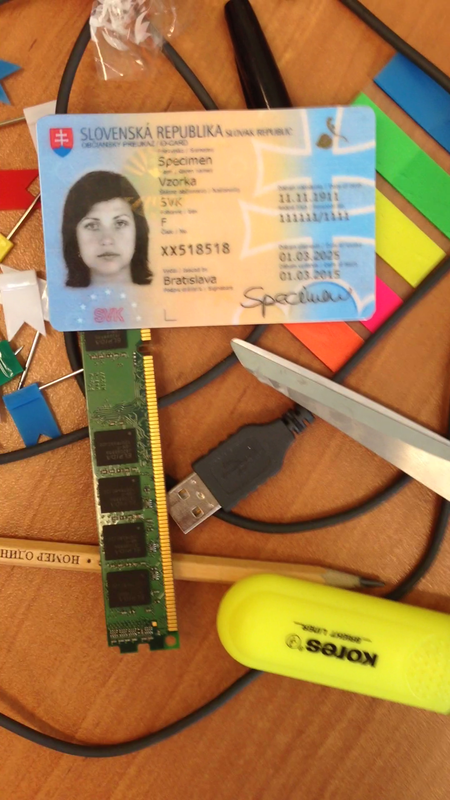

In [7]:
# Можно посмотреть изображения и разметку; в .quadrangle используются относительные единицы
print(di.quadrangle)
di.image

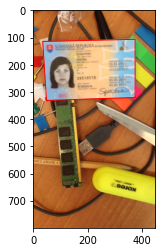

In [8]:
# Можно отрисовать разметку
# Не обязательно весь документ виден в кадре
di.show()

In [9]:
# DataItem содержит в себе информацию, относится ли он к test_split и целиком ли разметка внутри кадра
di.is_test_split(), di.is_quad_inside()

(False, True)

False


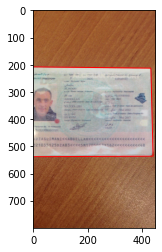

In [10]:
print(data_packs[38][238].is_test_split())
data_packs[38][238].show()

In [ ]:
## Статистика, как часто разметка не целиком в кадре
is_quad_inside = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_quad_inside.append(dp[i].is_quad_inside())
is_quad_inside = np.array(is_quad_inside).astype(int)
print(f"В {is_quad_inside.sum()} из {len(is_quad_inside)} случаев разметка кропа(т.е. документ) целиком в кадре")

100%|██████████| 50/50 [00:17<00:00,  2.90it/s]

В 9992 из 15000 случаев разметка кропа(т.е. документ) целиком в кадре


In [ ]:
## Статистика test-split
is_test_split = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_test_split.append(dp[i].is_test_split())
is_test_split = np.array(is_test_split).astype(int)
print(f"В {is_test_split.sum()} из {len(is_test_split)} случаев кадр принадлежит к test-split")

100%|██████████| 50/50 [00:00<00:00, 155.51it/s]

В 4250 из 15000 случаев кадр принадлежит к test-split


### Подготовка модели

In [11]:
# MODEL = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
MODEL = 'COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml'

In [12]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [13]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
predictor = DefaultPredictor(cfg)

model_final_a6e10b.pkl: 237MB [00:03, 61.4MB/s]                           


In [ ]:
img = np.array(di.image)
preds = predictor(img)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pyt

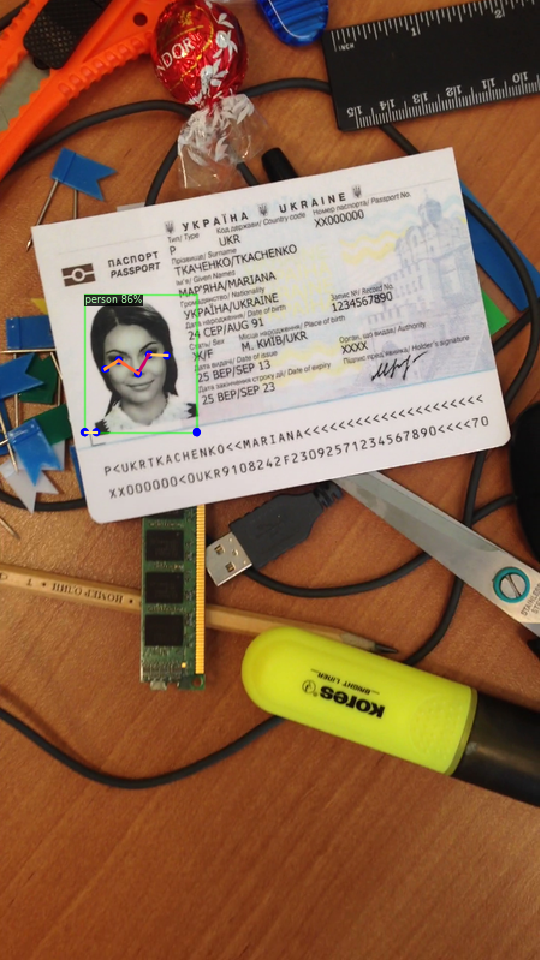

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(preds["instances"].to("cpu"))
cv2_imshow(out.get_image())

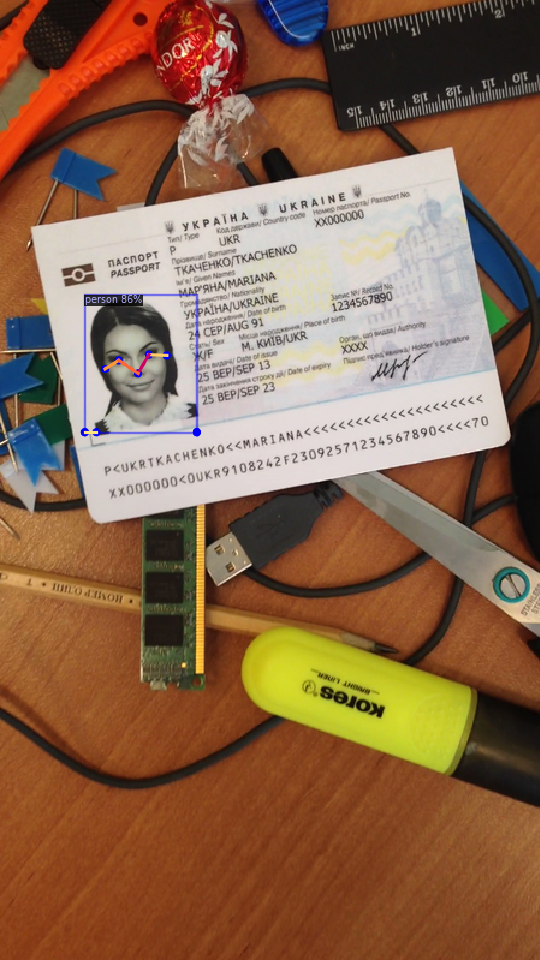

In [ ]:
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(preds["instances"][preds["instances"].scores >= 0.4].to("cpu"))
cv2_imshow(out.get_image())

In [14]:
di.gt_path, di.img_path

(PosixPath('/data/midv500_compressed/42_svk_id/ground_truth/CA/CA42_06.json'),
 PosixPath('/data/midv500_compressed/42_svk_id/images/CA/CA42_06.png'))

In [15]:
str(di.img_path).split('/')[-1][:-4]

'CA42_06'

In [16]:
print(di.image_size)

[450. 800.]


In [17]:
np.array(di.gt_data['quad'])

array([[ 35, 114],
       [375, 106],
       [375, 320],
       [ 49, 331]])

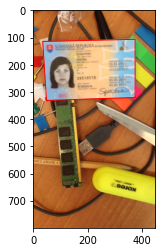

In [18]:
di.show()

### Подготовка датасета

In [19]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_dicts(dataset_packs, train_set=True):

    dataset_dicts = []
    for data_pack in dataset_packs:
        for data_item in data_pack:
            if (train_set and data_item.is_test_split()) or \
            (not train_set and not data_item.is_test_split()):
                continue
            if train_set and not data_item.is_quad_inside():
                continue

            record = {}
            img_path = str(data_item.img_path)
            height = int(data_item.image_size[1])
            width = int(data_item.image_size[0])
            record['file_name'] = img_path
            record['image_id'] = img_path.split('/')[-1][:-4]
            record['height'] = height
            record['width'] = width
          
            keypoints = []
            for x, y in np.array(data_item.gt_data['quad']):
                visible = 2 if 0 <= x < width and 0 <= y < height else 0
                if visible == 2:
                    keypoints.extend([x, y])
                else:
                    keypoints.extend([0, 0])
                keypoints.append(visible)

            quad = np.array(data_item.gt_data['quad'])
            p2 = max(quad[:, 0])
            p1 = min(quad[:, 0])
            q2 = max(quad[:, 1])
            q1 = min(quad[:, 1])

            w = p2 - p1
            h = q2 - q1

            cx = (p1 + p2) / 2
            cy = (q1 + q2) / 2

            box = [p1, q1, w, h]

            obj = {
                'bbox': box,
                'bbox_mode': BoxMode.XYWH_ABS,
                'keypoints': keypoints,
                'category_id': 0,
            }

            record['annotations'] = [obj]
            dataset_dicts.append(record)

    return dataset_dicts

for d in ['train', 'val']:
    DatasetCatalog.register('id_' + d, lambda d = d: 
              get_dicts(data_packs, train_set = d == 'train'))
    MetadataCatalog.get('id_' + d).set(thing_classes = ['id'], 
                                       keypoint_names = ['1', '2', '3', '4'],
                                       keypoint_flip_map = [('1', '2'), ('3', '4')])
    
text_metadata = MetadataCatalog.get('id_train')

In [20]:
dataset_dicts = get_dicts(data_packs, train_set=True)

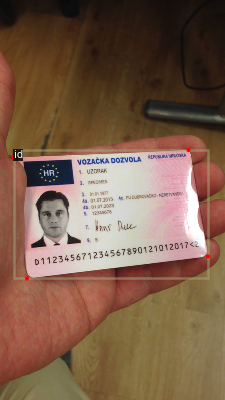

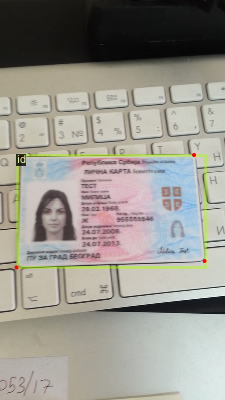

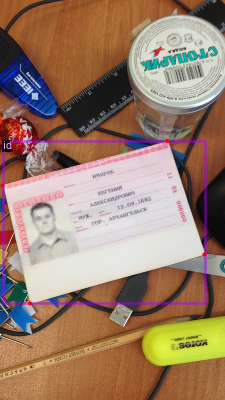

In [21]:
n = 0
while n < 3:
    pic = random.choice(dataset_dicts)
    if not pic['annotations']:
        continue
    img = cv2.imread(pic['file_name'])
    visualizer = Visualizer(img[:, :, ::-1], metadata=text_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(pic)
    cv2_imshow(out.get_image()[:, :, ::-1])
    n += 1

In [22]:
pic

{'annotations': [{'bbox': [5, 282, 404, 325],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 0,
   'keypoints': [5, 371, 2, 335, 282, 2, 409, 509, 2, 60, 607, 2]}],
 'file_name': '/data/midv500_compressed/39_rus_internalpassport/images/CA/CA39_09.png',
 'height': 800,
 'image_id': 'CA39_09',
 'width': 450}

### Запуск тренировки

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = ("id_train",)
cfg.DATASETS.TEST = ("id_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL)
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.LR_POLICY = 'steps_with_decay'
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MAX_ITER = 400
cfg.SOLVER.STEPS = [200]
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 4
cfg.MODEL.ROI_KEYPOINT_HEAD.LOSS_WEIGHT = 1
cfg.INPUT.RANDOM_FLIP = "none"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/22 17:46:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 4, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.keypoint_head.score_lowres.{bias, weight}


[03/22 17:46:09 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of 

[03/22 17:48:58 d2.utils.events]:  eta: 0:53:49  iter: 19  total_loss: 8.519  loss_cls: 0.2413  loss_box_reg: 0.1203  loss_keypoint: 8.128  loss_rpn_cls: 0.009001  loss_rpn_loc: 0.01257  time: 8.4904  data_time: 0.1849  lr: 5.7025e-05  max_mem: 9161M
[03/22 17:51:46 d2.utils.events]:  eta: 0:50:46  iter: 39  total_loss: 8.254  loss_cls: 0.161  loss_box_reg: 0.09907  loss_keypoint: 7.972  loss_rpn_cls: 0.00652  loss_rpn_loc: 0.01217  time: 8.4486  data_time: 0.1724  lr: 0.00010653  max_mem: 9161M
[03/22 17:54:34 d2.utils.events]:  eta: 0:47:51  iter: 59  total_loss: 7.85  loss_cls: 0.08838  loss_box_reg: 0.07155  loss_keypoint: 7.653  loss_rpn_cls: 0.005696  loss_rpn_loc: 0.01033  time: 8.4308  data_time: 0.1753  lr: 0.00015603  max_mem: 9161M
[03/22 17:57:22 d2.utils.events]:  eta: 0:45:01  iter: 79  total_loss: 6.947  loss_cls: 0.07185  loss_box_reg: 0.07116  loss_keypoint: 6.778  loss_rpn_cls: 0.005032  loss_rpn_loc: 0.01089  time: 8.4153  data_time: 0.1672  lr: 0.00020553  max_mem: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

In [23]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL))
cfg.DATASETS.TRAIN = ("id_train",)
cfg.DATASETS.TEST = ("id_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/MIPT/OCR/hw1/model_final.pth"
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.LR_POLICY = 'steps_with_decay'
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = [200]
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 4
cfg.MODEL.ROI_KEYPOINT_HEAD.LOSS_WEIGHT = 1
cfg.INPUT.RANDOM_FLIP = "none"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [24]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/22 19:03:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of 

[03/22 19:06:38 d2.utils.events]:  eta: 0:38:07  iter: 19  total_loss: 1.177  loss_cls: 0.01362  loss_box_reg: 0.007896  loss_keypoint: 1.155  loss_rpn_cls: 0.0007472  loss_rpn_loc: 0.002744  time: 8.1435  data_time: 0.2072  lr: 7.27e-06  max_mem: 9162M
[03/22 19:09:21 d2.utils.events]:  eta: 0:35:28  iter: 39  total_loss: 1.088  loss_cls: 0.01212  loss_box_reg: 0.006894  loss_keypoint: 1.065  loss_rpn_cls: 0.00104  loss_rpn_loc: 0.002459  time: 8.1589  data_time: 0.1992  lr: 1.387e-05  max_mem: 9162M
[03/22 19:12:04 d2.utils.events]:  eta: 0:32:47  iter: 59  total_loss: 1.024  loss_cls: 0.01353  loss_box_reg: 0.007389  loss_keypoint: 0.9938  loss_rpn_cls: 0.0009097  loss_rpn_loc: 0.002597  time: 8.1580  data_time: 0.2043  lr: 2.047e-05  max_mem: 9162M
[03/22 19:14:48 d2.utils.events]:  eta: 0:30:04  iter: 79  total_loss: 1.049  loss_cls: 0.01219  loss_box_reg: 0.007353  loss_keypoint: 1.029  loss_rpn_cls: 0.0006098  loss_rpn_loc: 0.002364  time: 8.1676  data_time: 0.1932  lr: 2.707e-0

### Оценка модели

In [25]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/MIPT/OCR/hw1/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

In [26]:
img = np.array(di.image)
preds = predictor(img)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


In [27]:
preds['instances'].pred_keypoints.size()

torch.Size([1, 4, 3])

In [28]:
preds['instances'].pred_boxes

Boxes(tensor([[ 26.4373, 104.9145, 379.6847, 334.2079]], device='cuda:0'))

In [29]:
preds['instances'].pred_keypoints

tensor([[[ 27.3369, 115.9900,   0.8968],
         [378.7851, 105.8125,   0.9145],
         [378.7851, 318.3430,   0.9666],
         [ 47.1284, 333.3099,   0.6682]]], device='cuda:0')

In [30]:
preds = np.array(predictor(img)['instances'].pred_keypoints.cpu())
preds = preds[0][:4, :2]
preds[:, 0] = preds[:, 0] / di.image_size[0]
preds[:, 1] = preds[:, 1] / di.image_size[1]
preds

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


array([[0.06074873, 0.14498755],
       [0.8417446 , 0.13226566],
       [0.8417446 , 0.39792868],
       [0.10472972, 0.4166374 ]], dtype=float32)

In [31]:
di.image_size

array([450., 800.])

In [32]:
print(preds, di.quadrangle)

[[0.06074873 0.14498755]
 [0.8417446  0.13226566]
 [0.8417446  0.39792868]
 [0.10472972 0.4166374 ]] [[0.07777778 0.1425    ]
 [0.83333333 0.1325    ]
 [0.83333333 0.4       ]
 [0.10888889 0.41375   ]]


In [33]:
results_dict = dict()

for dp in tqdm(data_packs):
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                img = np.array(dp[i].image)
                preds = np.array(predictor(img)['instances'].pred_keypoints.cpu())
                preds = preds[0][:4, :2]
                preds[:, 0] = preds[:, 0] / di.image_size[0]
                preds[:, 1] = preds[:, 1] / di.image_size[1]
                results_dict[dp[i].unique_key] = preds
            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
                print(exc)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='flo

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 10%|█         | 5/50 [03:29<29:37, 39.49s/it]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 18%|█▊        | 9/50 [04:53<16:55, 24.77s/it]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 22%|██▏       | 11/50 [07:19<29:18, 45.10s/it]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 44%|████▍     | 22/50 [12:53<10:22, 22.24s/it]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 70%|███████   | 35/50 [19:09<05:20, 21.34s/it]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 82%|████████▏ | 41/50 [23:00<03:56, 26.25s/it]

index 0 is out of bounds for axis 0 with size 0


 88%|████████▊ | 44/50 [24:02<02:16, 22.70s/it]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


100%|██████████| 50/50 [29:36<00:00, 35.52s/it]


In [34]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

dump_results_dict(results_dict, "/content/drive/MyDrive/MIPT/OCR/hw1/pred.json")

In [35]:
acc = measure_crop_accuracy(
    "/content/drive/MyDrive/MIPT/OCR/hw1/pred.json",
    "/content/drive/MyDrive/MIPT/OCR/hw1/gt.json"
)
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.5106


So close...  
Был бы рад подсказке/наводке, что не так и как можно улучшить точность :)  
И как лучше поступить с фото, где документ изображён не целиком?

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


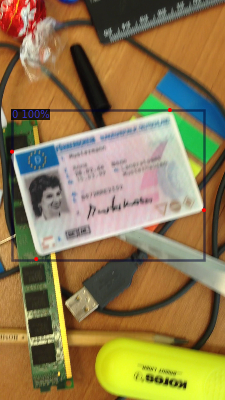

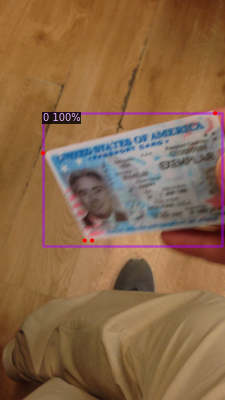

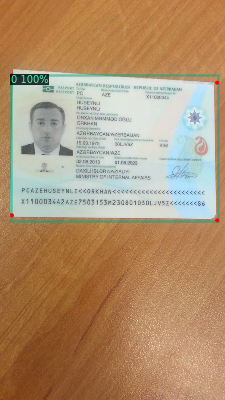

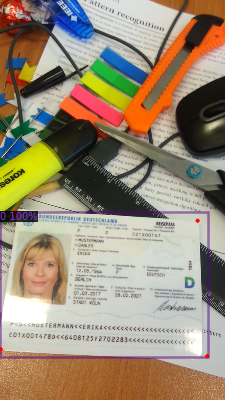

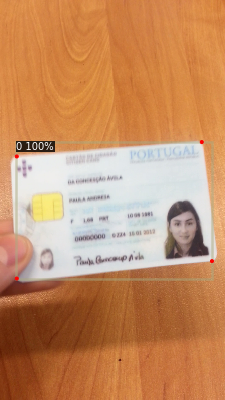

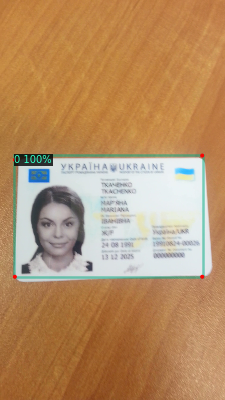

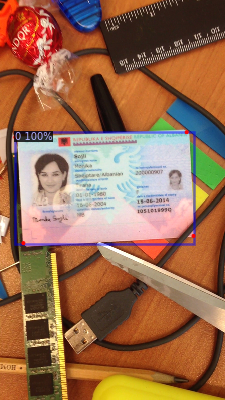

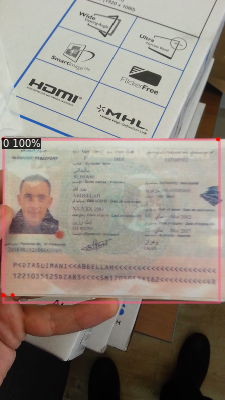

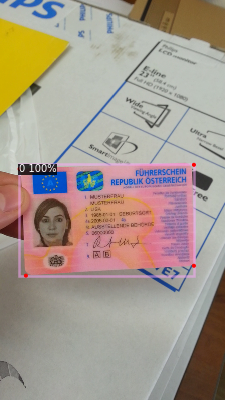

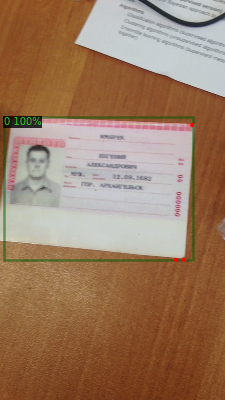

In [37]:
dataset_dicts = get_dicts(data_packs, train_set=False)

n = 0
while n < 10:
    pic = random.choice(dataset_dicts)
    if not pic["annotations"]:
        continue
    im = cv2.imread(pic["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    outputs = outputs["instances"].to("cpu")
    high_score_outputs = outputs[outputs.scores >= 0.35]
    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('id_valid'), scale=0.5)
    out = v.draw_instance_predictions(high_score_outputs)
    cv2_imshow(out.get_image()[:, :, ::-1])
    n += 1